<a href="https://colab.research.google.com/github/heychhavi/House-Price-Prediction/blob/main/Case_1_(Part_I)_HousePricePrediction(Exercises).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case 1 (Part I): House price prediction

In this case (Part I), you will build a multilayer perceptron network to predict the selling price of properties. The dataset consists of all single family houses and condos that were sold in Denver in a given year.

You need to submit the following files on canvas site:

- A report in the pdf format containing the plots of the training errors for the multi-layer perception model and the linear regression model, and the answers to the two questions below.

- The complete Jupyter notebook containing all your Pytorch code with explanations, along with a Markdown text explaining different parts if needed.




---
## Kaggle community competition: Prof. X's Prize


You need to set up a Kaggle account and joined the Kaggle competition by following the [link](https://www.kaggle.com/t/3d9270b9cc774238bdcc8209bd705cbf).

- Name your team as Section_X_Team_Y, where X is either A or B or C or D, and Y is your team number.
- One of the team members can serve as team leader and invite other members of your team to join the team.

- Each team can submit at most 20 predictions daily

To get the test error for your model, you need to submit your predicted prices for test data on Kaggle. See Kaggle competition website for more detailed instructions. Note that in Part I of the case, you do not need to worry about optimizing your model to get the lowest error possible. The Part I will be graded based on your implemention of the base models as specified below.  We will come back to optimize the model and compete for Prof. X's Prize in Part II of the case.

---
## Data Loading and Visualize Data


The train data and test data are available on the Kaggle competition website.
You need to first download them, then upload them to the google colab, and then read the data using pandas.

In [462]:
import pandas as pd  # Importing pandas, which is a library for data manipulation and analysis
#Read the datasets
train_df =pd.read_csv("train.csv")
test_df =pd.read_csv("test.csv")

In [463]:
train_df.head()

,ID,NBHD,PROP_CLASS,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,STYLE_CN,UNITS,SALE_PRICE
0,454754,MONTCLAIR,CONDOMINIUMS,928,0,0,0,0,60,4.0,2.0,2.0,0,1.0,END UNIT,1.0,285000
1,190773,HIGHLAND,SINGLE FAMILY RESIDENCE,2338,900,948,3125,0,6,NaN,3.0,4.0,1,3.0,END UNIT,1.0,1230000
2,159143,ATHMAR PARK,SINGLE FAMILY RESIDENCE,999,757,807,8900,0,67,6.0,3.0,2.0,0,1.0,1 STORY,1.0,420000
3,110649,MONTCLAIR,SINGLE FAMILY RESIDENCE,876,0,0,6100,0,77,15.0,2.0,1.0,0,1.0,1 STORY,1.0,355000
4,694203,GATEWAY / GREEN VALLEY RANCH,SINGLE FAMILY RESIDENCE,1729,0,0,2160,0,1,NaN,3.0,2.0,1,2.0,MIDDLE UNIT,1.0,339500


### Visualization of SALE PRICES in train data

Let's take a closer look at the sale prices in the train data.

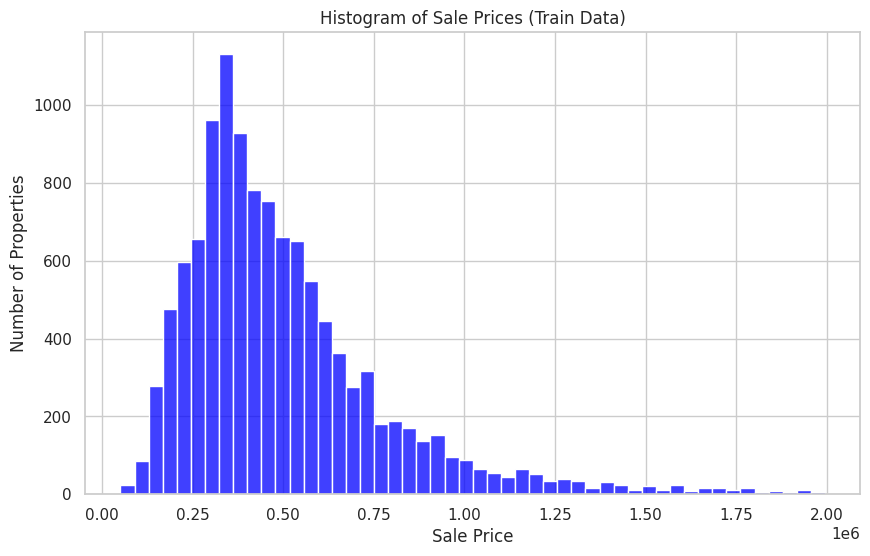

In [464]:
import seaborn as sns
import matplotlib.pyplot as plt  # Importing matplotlib's pyplot for making plots and charts

# Set the style
sns.set(style="whitegrid")

# Create a histogram
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SALE_PRICE'], bins=50, color='blue')
plt.title('Histogram of Sale Prices (Train Data)')
plt.xlabel('Sale Price')
plt.ylabel('Number of Properties')
plt.show()

---
## Data Preparation

The first step when building a neural network model is getting your data into the proper form to feed into the network.

- **Train labels**: We need to extract the sale prices from the train data as train labels. Since the house prices can take very large values, to make training fast it is helpful to define the train labels as the sale prices divided by a normalization factor.

- **Handing non-numeric features**: Some of the house features are non-numeric. We will learn about how to process categorical data in the upcoming lectures. For now, you can  remove those non-numeric features and only train over the numeric features.

- **Feature standardization**: When predicting house prices, you started from features that took a variety of ranges—some features had small floating-point values, and others had fairly large integer values. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input dataframe), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has
a unit standard deviation. **Note**: We need to ensure that the train and test data go through the same normalization.

- **Handling missing values**: There may exist some entries with missing values. After the feature standardization, we can impute the missing values with zeros.

#### Train labels

We see that the sale_price in train data has a wide range from 50K to 2 million, with the median price 431K. We can divide the sale_price by 100K, so the normalized sale_price is between 0.5 and 20 in training data. Remember, when we output the predicted price for the test data, we need to multiply back the normalization factor.

In [465]:
#TODO: Write code to construct feature vectors for train and test data after data preparation.
train_df = train_df.drop(columns = ['ID'])
test_df = test_df.drop(columns = ['ID'])

In [466]:
#TODO: define labels for train data as the sale prices divided by $100,000
normalization_factor=100000
train_labels = train_df['SALE_PRICE']/normalization_factor

In [467]:
train_labels

0         2.850
1        12.300
2         4.200
3         3.550
4         3.395
          ...  
11576     3.149
11577     5.395
11578     6.020
11579     3.837
11580     5.500
Name: SALE_PRICE, Length: 11581, dtype: float64

In [468]:
train_features = train_df.drop(columns = ['SALE_PRICE'])
test_features = test_df

In [469]:
train_labels.shape

(11581,)

####Handing non-numeric features

In [470]:
train_features.dtypes

NBHD            object
PROP_CLASS      object
LIVING_SQFT      int64
FBSMT_SQFT       int64
BSMT_AREA        int64
LAND_SQFT        int64
GRD_AREA         int64
BLDG_AGE         int64
RM_AGE         float64
BED_RMS        float64
FULL_B         float64
HLF_B            int64
STORY          float64
STYLE_CN        object
UNITS          float64
dtype: object

In [471]:
train_features = train_features.select_dtypes(exclude=['object'])
test_features = test_features.select_dtypes(exclude=['object'])

In [472]:
train_features.shape, test_features.shape

((11581, 12), (4964, 12))

#### Handling missing values

In [473]:
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

#### Feature standardization

In [474]:
train_features.describe()

,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,UNITS
count,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000,11581.000000
mean,1455.272515,325.328037,458.812538,3932.483637,18.771522,46.301615,3.206027,2.446335,2.052327,0.420603,1.488516,1.016579
std,708.466454,468.867156,555.551763,3458.545954,113.896776,38.208671,6.543955,0.897795,0.877580,0.540601,0.647499,0.159559
min,314.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,952.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
50%,1272.000000,0.000000,0.000000,3610.000000,0.000000,47.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000
75%,1764.000000,723.000000,905.000000,6250.000000,0.000000,70.000000,3.000000,3.000000,3.000000,1.000000,2.000000,1.000000
max,6812.000000,3210.000000,4439.000000,36900.000000,1710.000000,142.000000,77.000000,8.000000,8.000000,3.000000,4.000000,5.000000


In [475]:
test_features.describe()

,LIVING_SQFT,FBSMT_SQFT,BSMT_AREA,LAND_SQFT,GRD_AREA,BLDG_AGE,RM_AGE,BED_RMS,FULL_B,HLF_B,STORY,UNITS
count,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000,4964.000000
mean,1452.580782,313.368856,448.121273,3948.503022,21.109186,46.496575,3.118654,2.455479,2.060838,0.413981,1.476531,1.019541
std,718.058169,455.488958,548.675617,3444.968966,121.561303,38.301694,6.427561,0.905928,0.876821,0.538329,0.643167,0.167417
min,283.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,944.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
50%,1261.000000,0.000000,0.000000,3723.000000,0.000000,47.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000
75%,1755.250000,688.250000,881.250000,6250.000000,0.000000,70.000000,3.000000,3.000000,3.000000,1.000000,2.000000,1.000000
max,5535.000000,2348.000000,3216.000000,29079.000000,1959.000000,139.000000,77.000000,7.000000,7.000000,3.000000,4.000000,5.000000


In [476]:
## train data normalization
#mean = train_features.mean()
#std = train_features.std()
#train_features = (train_features - mean) / std

In [477]:
## test data normalization
#mean = test_features.mean()
#std = test_features.std()
#test_features = (test_features - mean) / std

In [478]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

Finally, we convert features and labels to PyTorch tensors.

In [479]:
import torch
import numpy as np

# Convert training features and labels to PyTorch tensors
#train_features = torch.tensor(train_features.values.astype(np.float32), dtype=torch.float32)
#test_features = torch.tensor(test_features.values.astype(np.float32), dtype=torch.float32)
#train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)
train_features = torch.tensor(train_features.tolist(), dtype=torch.float32)
test_features = torch.tensor(test_features.tolist(), dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1).astype(np.float32), dtype=torch.float32)


---
## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for this data by following two steps:
1. Create a known format for accessing our data, using [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) which takes in an input set of data and a target set of data with the same first dimension, and creates a dataset.
2. Create DataLoaders and batch our training, validation, and test Tensor datasets. Note that we will shuffle the train data, so the model will not learn a particular order. For test data, we do not shuffle.

In [480]:
np.random.seed(10)

In [481]:
from torch.utils.data import TensorDataset, DataLoader
#  Create DataLoaders and batch our train data
train_data = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [482]:
#TODO: Create DataLoaders and batch for test data
#test_data = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_features, batch_size =64, shuffle=False)

Let's take a batch to have a sanity check

In [483]:
# obtain one batch of training data
dataiter = iter(train_loader)
features, labels = next(dataiter)

print('Sample input size: ', features.size()) # batch_size, seq_length
print('Sample input: \n', features)
print()
print('Sample label size: ', labels.size()) # batch_size
print('Sample label: \n', labels)

Sample input size:  torch.Size([128, 12])
Sample input: 
 tensor([[-0.1105, -0.6939, -0.8259,  ..., -0.7781,  2.3344, -0.1039],
        [-0.3688, -0.6939, -0.8259,  ...,  1.0718,  0.7900, -0.1039],
        [-0.3773,  1.6907,  1.3126,  ...,  1.0718, -0.7545, -0.1039],
        ...,
        [ 0.7830, -0.6939, -0.8259,  ...,  1.0718,  0.7900, -0.1039],
        [ 0.0151, -0.6939, -0.8259,  ..., -0.7781,  1.5622, -0.1039],
        [-1.0266, -0.6939, -0.8259,  ..., -0.7781, -0.7545, -0.1039]])

Sample label size:  torch.Size([128, 1])
Sample label: 
 tensor([[ 5.5000],
        [ 3.2000],
        [ 4.2000],
        [ 2.9700],
        [ 4.2500],
        [ 5.2500],
        [ 6.0500],
        [ 4.2500],
        [ 2.3990],
        [ 9.6000],
        [ 1.6000],
        [ 3.7500],
        [ 9.5000],
        [ 2.7500],
        [ 1.5000],
        [ 3.7100],
        [ 8.6500],
        [ 1.6900],
        [ 3.3000],
        [ 1.7200],
        [ 3.5500],
        [ 7.0000],
        [ 3.0500],
        [ 4.1

---
## Linear regression as benchmark

Let us first build a linear regression model as a benchmark.

In [484]:
#TODO: Build a linear regression model network
import torch.nn as nn
lin_net = nn.Linear(12,1)


Let's take a batch and see the output

In [485]:
labels.shape

torch.Size([128, 1])

In [486]:
features, labels = next(dataiter)
output=lin_net(features)
output.shape,labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

## Train the model

First, we will use GPU training if it is availabe.

In [487]:
#TODO: use GPU for training if it is availabe

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')


Second, let us specify the loss function.

In [488]:
import torch
import torch.nn as nn

class MedianErrorRateLoss(nn.Module):
    def __init__(self):
        super(MedianErrorRateLoss, self).__init__()

    def forward(self, predicted, actual):
        # Calculate the absolute error for each prediction
        absolute_error = torch.abs((predicted - actual)/actual)

        # Calculate the error rate for each prediction
        #error_rate = absolute_error / (actual + 1e-10)  # Avoid division by zero

        # Calculate the median error rate
        #sorted_error_rates, _ = torch.sort(error_rate)
        #num_samples = error_rate.size(0)
        #median_index = num_samples // 2
        #median_error_rate = sorted_error_rates[median_index]

        return absolute_error

# Example usage:
criterion = MedianErrorRateLoss()
optimizer = torch.optim.SGD(lin_net.parameters(), lr = 0.003)

We are now ready to train the network.


Note that with house prices, as with stock prices, we care about relative quantities more than absolute quantities. Thus we tend to care more about the relative error than about the absolute error. For instance, if our prediction is off by \\$100,000 when estimating the sale price of a house which is \\$125,000, then we are probably doing a horrible job. On the other hand, if we err by this amount for a house with sale price \\$2 million, this might represent a pretty  accurate prediction.

To this end, we will use the median error rate (MER) used by [Zestimate](https://www.zillow.com/z/zestimate/) to measure the predictive performance. The error rate is defined as
$$
\text{Error Rate} = \left| \frac{\text{Predicted Price}-\text{Actual Price}}{\text{Actual Price}} \right|
$$
The median error rate is defined as the median of error rates for all properties.

In [492]:
#TODO: Write code to train the network
epochs = 10
train_losses_2 = []
for i in range(epochs):
  running_loss = 0
  for train_features, train_lables in train_loader:
    #train_data = torch.utils.data.to_tensor(train_data)
    train_features = train_features.view(train_features.shape[0], -1)
    train_labels = train_labels.reshape(-1)
    train_data = train_features.to(device)
    train_labels = train_labels.to(device)
    lin_net = lin_net.to(device)
    optimizer.zero_grad()
    output = lin_net(train_data)
    loss = criterion(output, train_labels)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
        train_loss=running_loss/len(train_loader)
        train_losses_2.append(train_loss)
        print(f"Training loss: {train_loss}")


Training loss: 0.5274667412370115
Training loss: 0.5191635063716343
Training loss: 0.5113824920339899
Training loss: 0.5040028655267024
Training loss: 0.49696104375870676
Training loss: 0.4904143030826862
Training loss: 0.48422875509157287
Training loss: 0.4786135085991451
Training loss: 0.47291778601132906
Training loss: 0.4678143904759334


Plot the training error (MER) over epochs

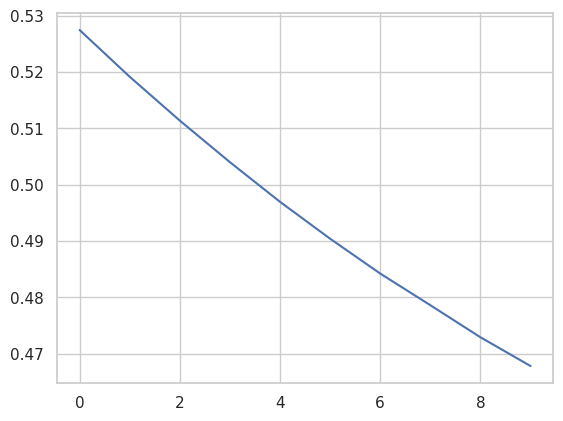

In [493]:
#TODO: Write code to plot the training error (MER) over epochs
import matplotlib.pyplot as plt
plt.plot(train_losses_2, label='Train loss (lr=0.01)')

---
## Build the Multi-layer Perceptron Base Model

In the following, we build a multi-layer perception model.

In [494]:
#TODO: Build a multi-layer perception neural network with 2 hidden layers of sizes 256 and 128, respectively and ReLu activations
MLP_net= nn.Sequential(nn.Linear(12, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128, 1),
                      )

In [495]:
#TODO: write code to train the MLP network
learning_rate = 0.01 # You can adjust this value
optimizer = torch.optim.Adam(MLP_net.parameters(), lr=learning_rate)
criterion = MedianErrorRateLoss()
# Set your device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MLP_net = MLP_net.to(device)

# Training loop
epochs = 20
train_losses_m = []
for epoch in range(epochs):
    running_loss = 0.0
    for train_features, train_labels in train_loader:  # Assuming you have a DataLoader set up
        train_features = train_features.view(train_features.shape[0], -1)
        #train_labels = train_labels.view(-1)
        train_features = train_features.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        output = MLP_net(train_features)
        #output = output.to(torch.long)  # Convert the output to Long data type
        loss = criterion(output, train_labels)
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses_m.append(train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training loss: {train_loss}")

Epoch 1/20, Training loss: 0.2878689631655976
Epoch 2/20, Training loss: 0.24279120417086633
Epoch 3/20, Training loss: 0.22855514811945485
Epoch 4/20, Training loss: 0.22745371978361528
Epoch 5/20, Training loss: 0.21992221474647522
Epoch 6/20, Training loss: 0.21548174419900873
Epoch 7/20, Training loss: 0.21233988250349903
Epoch 8/20, Training loss: 0.2120005101947994
Epoch 9/20, Training loss: 0.2110310354075589
Epoch 10/20, Training loss: 0.20805863643085565
Epoch 11/20, Training loss: 0.20611902334532894
Epoch 12/20, Training loss: 0.20458648181878603
Epoch 13/20, Training loss: 0.2040393190397011
Epoch 14/20, Training loss: 0.20283341522400195
Epoch 15/20, Training loss: 0.20153949041287977
Epoch 16/20, Training loss: 0.20060112532023544
Epoch 17/20, Training loss: 0.19983056236754407
Epoch 18/20, Training loss: 0.20114543231633994
Epoch 19/20, Training loss: 0.19808423175261572
Epoch 20/20, Training loss: 0.19873310396304497


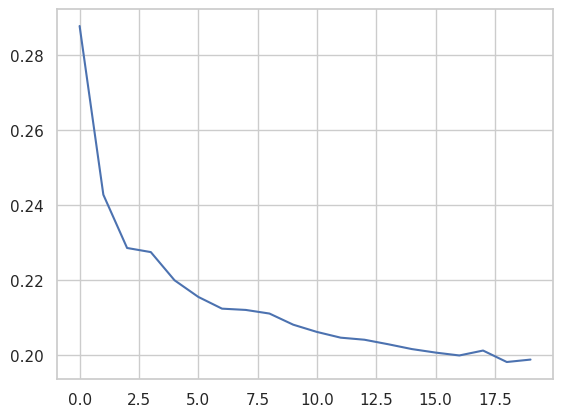

In [496]:
#TODO: Write code to plot the training error (MER) over epochs
plt.plot(train_losses_m, label='Train loss (lr=0.01)')

**Question 1**: What are your final training errors of the multilayer perception model and the linear regression model?

---
## Inference on test data

After the MLP model is trained, we can use it for inference.

In [497]:
#TODO: write the code to generate predicted sale prices for test data
# Predictions
original_predictions = []  # To store predictions in the original scale

for features in test_loader:
    features = features.to('cuda')
    predictions = MLP_net(features*Normalization)
    original_predictions.append(predictions)


original_predictions = torch.cat(original_predictions, dim=0)

In [498]:
original_predictions

tensor([[6.1326e+04],
        [8.1034e-01],
        [1.1946e+05],
        ...,
        [8.1034e-01],
        [2.2334e+03],
        [3.5278e+04]], device='cuda:0', grad_fn=<CatBackward0>)

In [499]:
numpy_array = original_predictions.detach().cpu().numpy()

# Create a Pandas DataFrame
df = pd.DataFrame(numpy_array, columns=["Predicted Sale Price"])

In [500]:
df.to_csv('test2.csv')

In [ ]:
#TODO: save the predicted sale prices into submission_csv
images = torch

Now, we can submit our predictions on Kaggle and see how they compare with the actual house prices (labels) on the test set.

- Log in to the Kaggle website and visit the house price prediction competition page.

- Click the “Submit Predictions”.

- Click the “Browse Files” button in the dashed box at the bottom of the page and select the prediction file you wish to upload.

- Click the “Submit” button at the bottom of the page to view your results.

**Question 2**: What is the test error shown on Kaggle? How does it compare with the train error?